# This notebook is Python data analysis Decathlon vacancy exam (adapted from ada 2017)
## Dataset description:

### pokemon.csv
### In this file, each row represents the features of one Pokémon.

### - pid: Numeric - ID of the Pokémon
### - HP: Numeric - Health points
### - Attack: Numeric - Strength of the regular attack
### - Defense: Numeric - Strength of the regular defense
### - Sp. Atk: Numeric - Strength of the special attack
### - Sp. Def: Numeric - Strength of the special defense
### - Speed: Numeric - Moving speed
### - Legendary: Boolean - ‘True’ if the Pokémon is rare
### - Class 1: Categorical - Pokémon class
### - Class 2: Categorical - Pokémon class

#### Note! Pokémon can have either one or two classes. If a Pokémon has two classes, they are both considered to have the same importance.

### combats.csv
### In this file, each row represents the outcome of one battle between two Pokémon.

### - First_pokemon: Numeric - ID (match with pid)
### - Second_pokemon: Numeric - ID (match with pid)
### - Winner: Numeric - ID of the winner

## Objectives:
### - Explore the datasets
### - Develope a model for predicting the outcome of battles between Pokemon
### - Devise a method for ranking Pokemon by their overall strength

In [140]:
# imports first
import time
import warnings
warnings.filterwarnings("ignore")

# imports to read the data and EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

# imports for ML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle

In [2]:
# read the data
pokemon = pd.read_csv("pokemon.csv")
combats = pd.read_csv("combats.csv")

### First, I need to look at datasets. Check number of columns and rows, information on the datasets, some descriptive statistics, deal with missing values if there are any.

In [3]:
# shape
print(f"Pokemon dataset has {pokemon.shape[0]} rows and {pokemon.shape[1]} columns")
print(f"Combats dataset has {combats.shape[0]} rows and {combats.shape[1]} columns")

Pokemon dataset has 800 rows and 11 columns
Combats dataset has 50000 rows and 3 columns


In [4]:
# look at first 5 rows of the datasets
pokemon.head()

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


In [5]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


### Some descriptive statistics of numeric values in pokemon dataset.

In [6]:
# describe
pokemon.describe()

,pid,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


### So, we have all kinds of pokemon in the dataset ranging from 1 to 255 in health points, 5 to 190 in attack points, 5 to 230 in defense points, 10 to 194 and 20 to 230 in special attack and special defense points respectively and 5 to 180 in speed points. I think it would be interesting to see if those pokemon with health points have better defense or stronger attack leads to a slower speed. Also it would be interesting to know if rare pokemon are generally better in combat than ordirnary ones.
### But before doing that I need to check for missing values.

In [7]:
# missing values?
pokemon.isnull().sum()

pid            0
Name           1
Class 1        0
Class 2      386
HP             0
Attack         0
Defense        0
Sp. Atk        0
Sp. Def        0
Speed          0
Legendary      0
dtype: int64

### 1 missing value in "Name" column. I think it does't really matter much as long as we have other data for this pokemon (which we do). So, I'll just call that pokemon "Unknown name". Some pokemon belong only to one class, hense 386 missing values in "Class 2" column. I'll put zeros instead of NaNs in that one.

In [8]:
pokemon["Name"].fillna("Unknown", inplace=True)
pokemon["Class 2"].fillna(0, inplace=True)

In [10]:
# double check for missing values. False would mean there isn't any
pokemon.isnull().sum().any()

False

In [11]:
combats.isnull().sum().any()

False

### Now it's time for some exploritory data analysis.
### First, I want to see how classes are distributed.

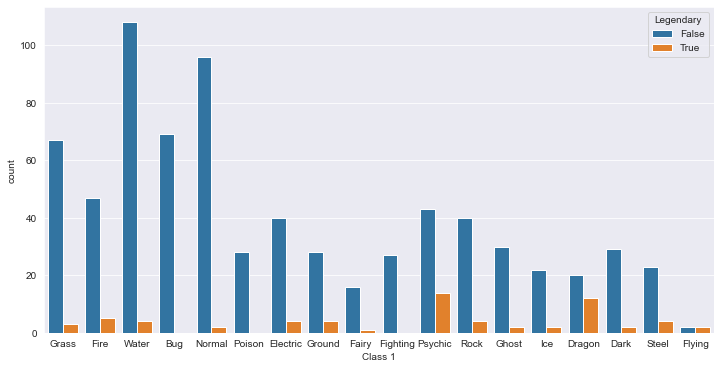

In [12]:
# First, number of pokemon in each class and how many of them are rare
plt.figure(figsize=(12,6))
sns.countplot(pokemon["Class 1"], hue=pokemon["Legendary"]);

### So water class is the most represented, followed by normal and grass classes. Interestingly, rare pokemon tend to appear in dragon and psychic classes (as their 1st class). And if you have a pokemon of bug or fighting class as their first class, well, chances they are rare close to 0. Overall, there are 18 different classes and I want to keep them in a list for future. 

In [13]:
# how classes are represented ("Class 1" column)
pokemon["Class 1"].value_counts()

Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Electric     44
Rock         44
Ghost        32
Dragon       32
Ground       32
Dark         31
Poison       28
Steel        27
Fighting     27
Ice          24
Fairy        17
Flying        4
Name: Class 1, dtype: int64

In [14]:
# list of classes in descendong order
pokemon_classes = list(pokemon["Class 1"].value_counts().index)

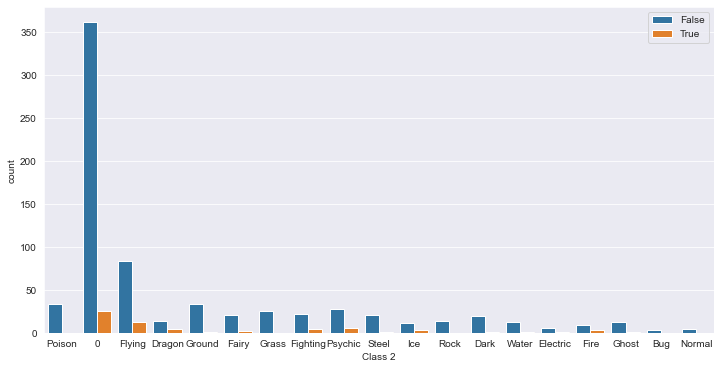

In [16]:
# how classes are represented in "Class 2" column
plt.figure(figsize=(12,6))
sns.countplot(pokemon["Class 2"], hue=pokemon["Legendary"])
plt.legend(loc="upper right");

### So, almost half of the pokemon belong to one class only but we already knew that (those 386 missing values turned into zeros above). Flying is the most represented as second class. And again, if, for example, you have a pokemon of bug or poison class they are not rare.
### Now, I want to see what is a second class of pokemon would be if the first class is water or dragon, etc. The plots will be separated in three parts from water class all the way to flying class as their Class 1.

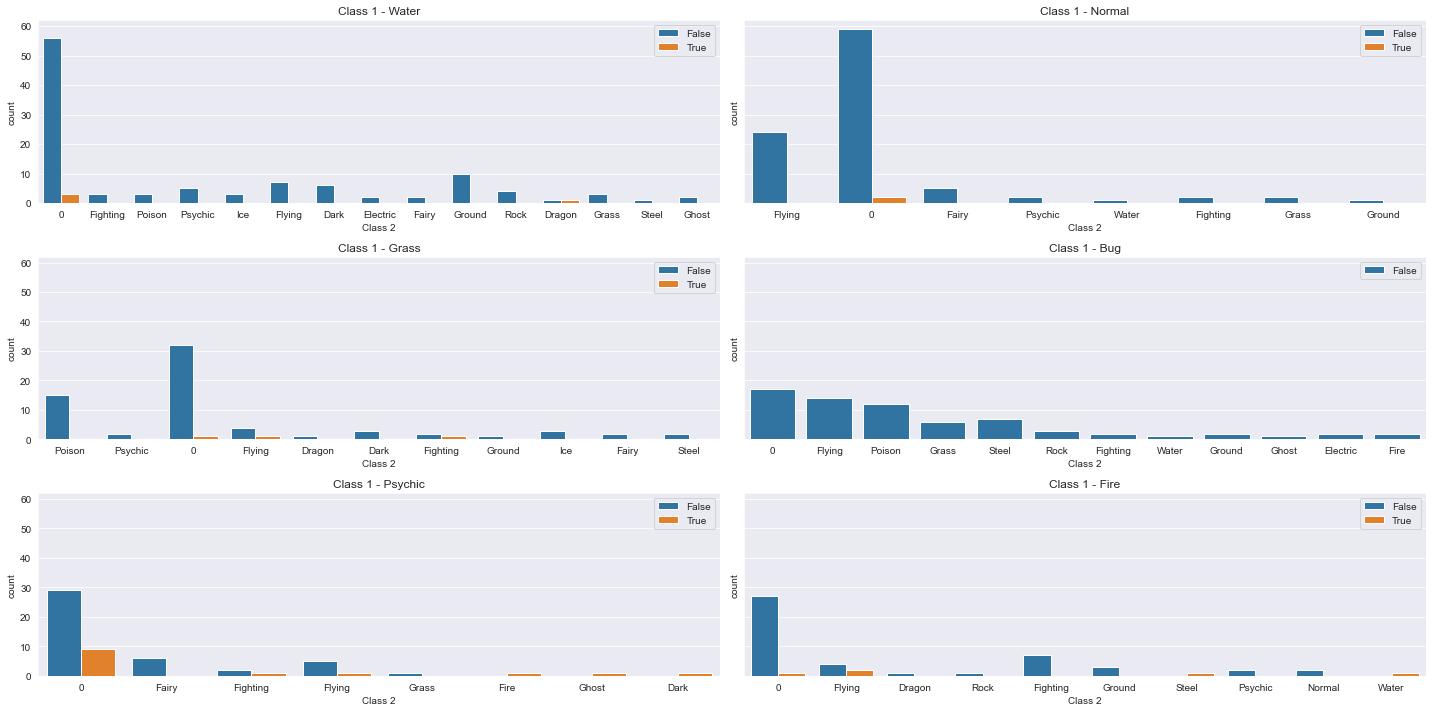

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20,10), sharey=True)
for ax,pokemon_class in zip(axes.flatten(),pokemon_classes[:6]):
    sns.countplot(x="Class 2", hue="Legendary", data=pokemon[pokemon["Class 1"]==pokemon_class], ax=ax)
    ax.set(title=f"Class 1 - {pokemon_class}")
    ax.legend(loc="upper right")
    plt.tight_layout()

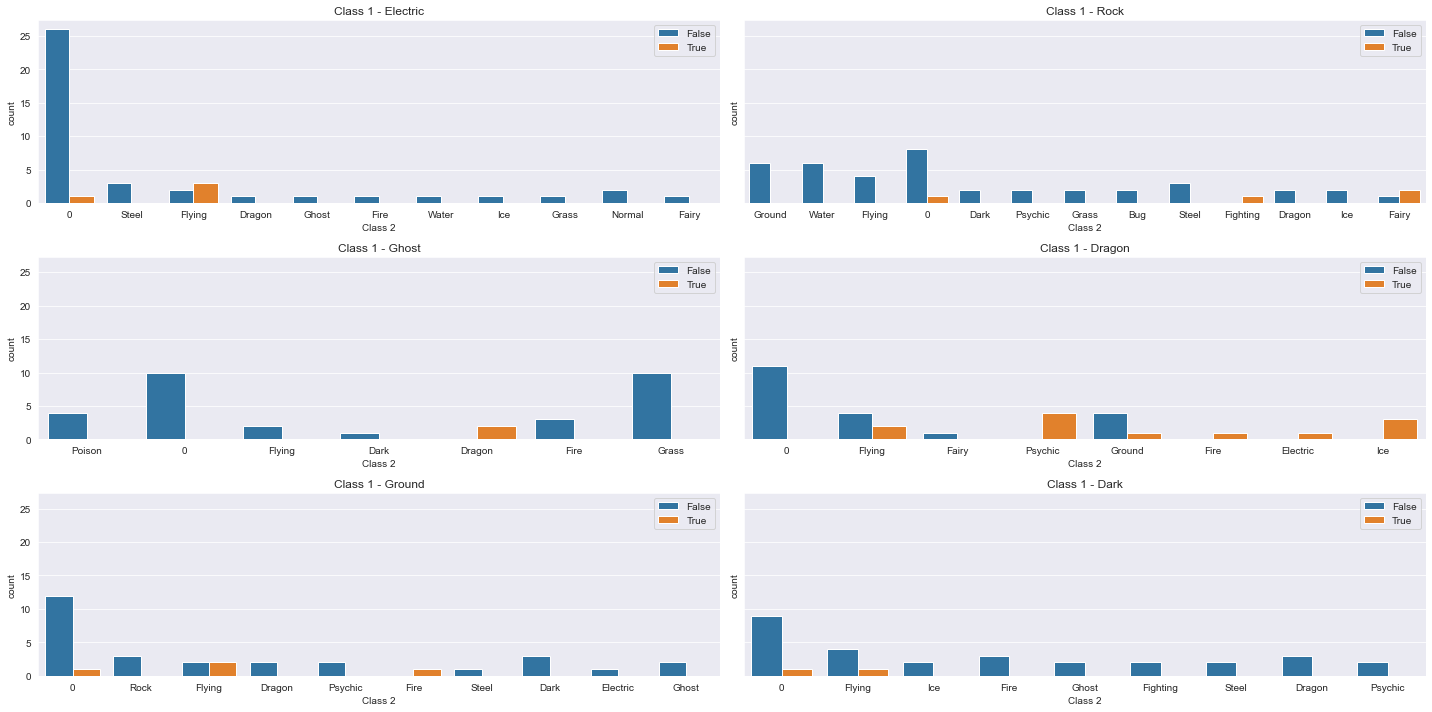

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20,10), sharey=True)
for ax,pokemon_class in zip(axes.flatten(),pokemon_classes[6:12]):
    sns.countplot(x="Class 2", hue="Legendary", data=pokemon[pokemon["Class 1"]==pokemon_class], ax=ax)
    ax.set(title=f"Class 1 - {pokemon_class}")
    ax.legend(loc="upper right")
    plt.tight_layout()

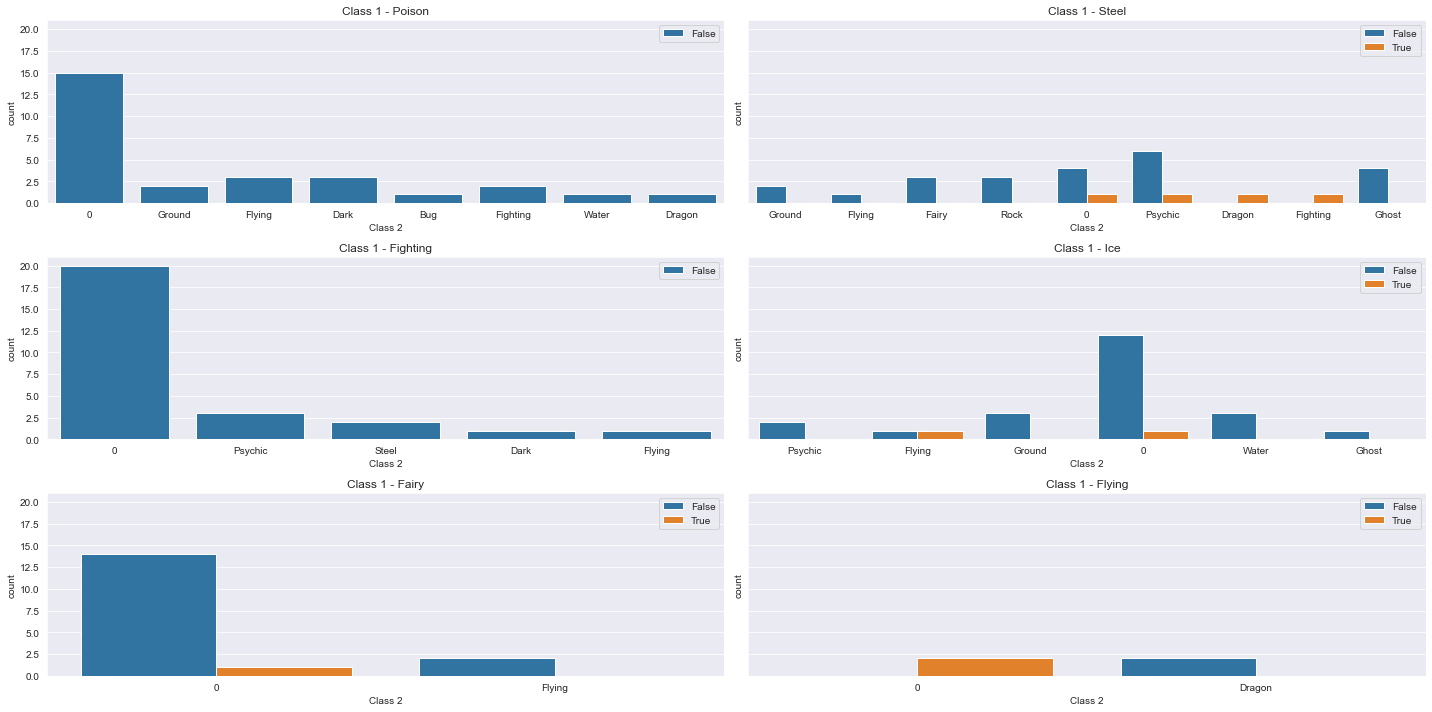

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20,10), sharey=True)
for ax,pokemon_class in zip(axes.flatten(),pokemon_classes[12:]):
    sns.countplot(x="Class 2", hue="Legendary", data=pokemon[pokemon["Class 1"]==pokemon_class], ax=ax)
    ax.set(title=f"Class 1 - {pokemon_class}")
    ax.legend(loc="upper right")
    plt.tight_layout()

## Here is what we have so far:
### - Water class is most common as pokemon's first class, flying is least.
### - More than half pokemons belongs only to one class, if they belong to a second class - flying is most common.
### - Some class and class combinations are very common (no rare species among them), e.g. bug, poison or fighting classes. While some class combinations are pretty rare, e.g. ghost-dragon, dragon-psychic, dragon-ice, etc. So if you have a dragon class pokemon, there is a high chance it's rare. After we build the ranking it will be interesting to see if those are the strongest pokemon.

### Now, let's see how pokemon's phisical attributes are distributed.

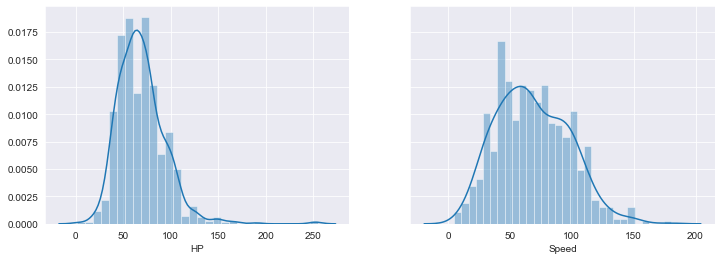

In [25]:
# health and speed
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
sns.distplot(pokemon["HP"], bins=30, ax=axes[0])
sns.distplot(pokemon["Speed"], bins=30, ax=axes[1]);

In [27]:
print(f"Avg health - {round(pokemon['HP'].mean(),2)} points")
print(f"Avg speed - {round(pokemon['Speed'].mean(),2)} points")

Avg health - 69.26 points
Avg speed - 68.28 points


### It looks like both HP points are more densely distributed around the average. There are some exceptions though of pokemons with extremely low or extremely high level of health points. Speed points are more widely distributed, although there are some "unique" very slow or very fast ones.

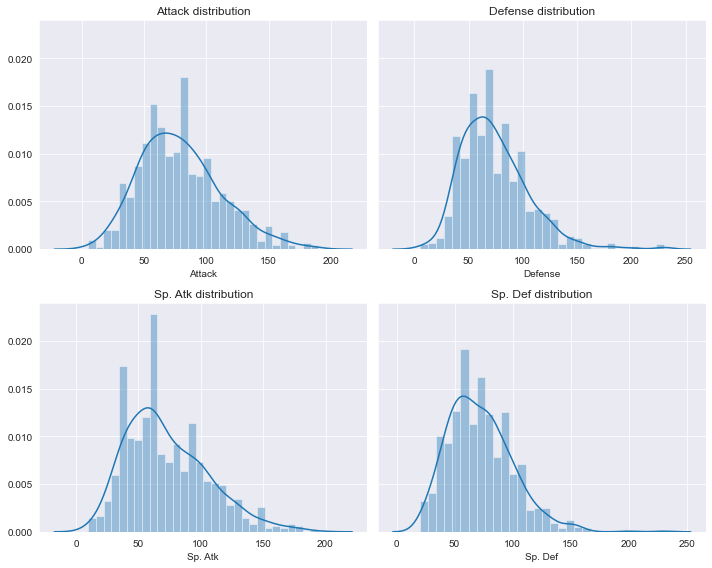

In [30]:
fig, axes = plt.subplots(2,2, figsize=(10,8), sharey=True)
for ax,col in zip(axes.flatten(),["Attack","Defense","Sp. Atk","Sp. Def"]):
    sns.distplot(pokemon[col], bins=30, ax=ax)
    ax.set(title=f"{col} distribution")
    plt.tight_layout();

In [31]:
print(f"Avg attack - {round(pokemon['Attack'].mean(),2)} points")
print(f"Avg defense - {round(pokemon['Defense'].mean(),2)} points")
print(f"Avg special attack - {round(pokemon['Sp. Atk'].mean(),2)} points")
print(f"Avg special defense - {round(pokemon['Sp. Def'].mean(),2)} points")

Avg attack - 79.0 points
Avg defense - 73.84 points
Avg special attack - 72.82 points
Avg special defense - 71.9 points


### Again, all four attributes are more or less distributed around respective average points with some exceptions of extremely high attack or defense points.
### Now, one thing I'd like to check. I think the higher pokemon's defense points the less his health points are and vice versa, or stronge attack leads to slower speed. Let's check that out.

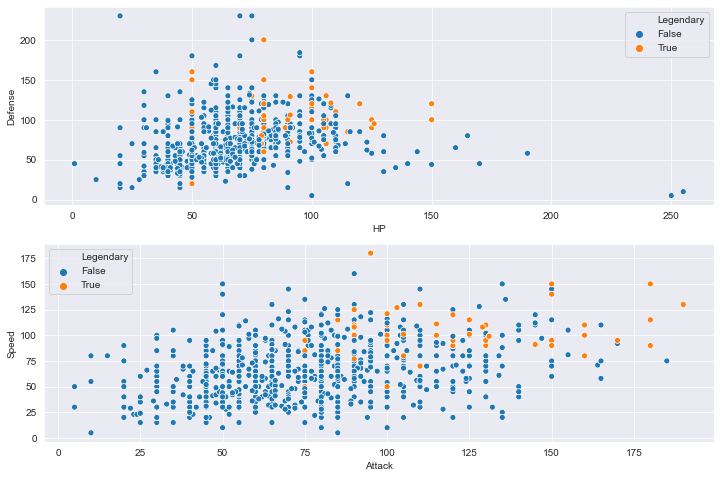

In [34]:
# health vs defense and atack vs speed. And see if that's true for rare pokemons as well
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
sns.scatterplot("HP", "Defense", hue="Legendary", data=pokemon, ax=axes[0])
sns.scatterplot("Attack", "Speed", hue="Legendary", data=pokemon, ax=axes[1]);

### It's not conclusive. Although there are pokemon with extremely high health and low defense points, there are also couple examples of pokemon with both health and defense being way below the average. With attack vs speed it seems to be the opposite of my theory. The higher attack, the higher speed tend to be.
### What about health vs speed and attack vs defense?

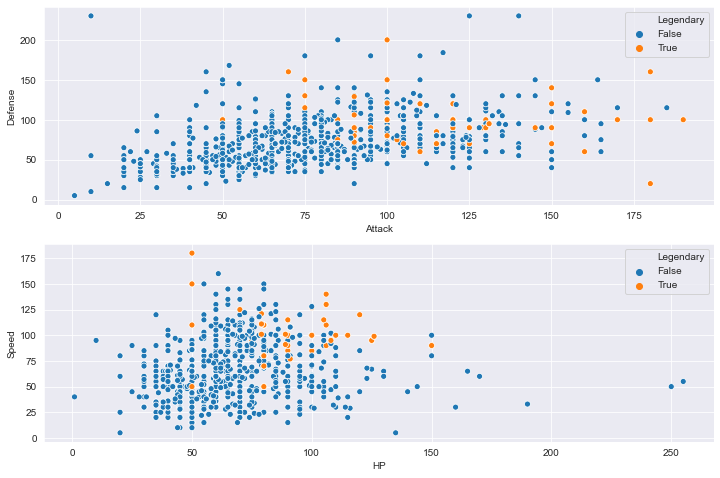

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
sns.scatterplot("Attack", "Defense", hue="Legendary", data=pokemon, ax=axes[0])
sns.scatterplot("HP", "Speed", hue="Legendary", data=pokemon, ax=axes[1]);

### These two plots are interesting. We have two trends: higher attack - higher defense tend to be, more health - less speed.

### Now, let's see how attack over defense ratio is distributed. I also have to list three pokemon with highest and three pokemon with slowest attack over defense ratio.

In [36]:
# see how attack/defense and sp.attack/sp.defense ratio is distributed
# need to create new columns for that
pokemon["Attack/Defense ratio"] = pokemon["Attack"] / pokemon["Defense"]
pokemon["Sp.Atk/Sp.Def ratio"] = pokemon["Sp. Atk"] / pokemon["Sp. Def"]

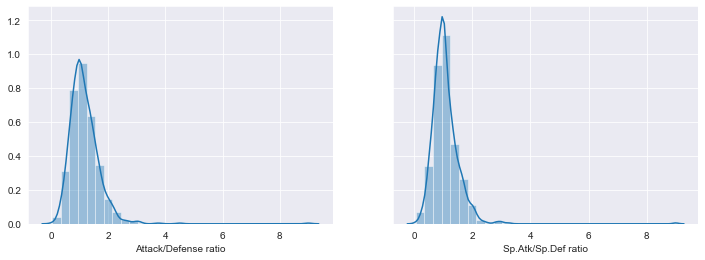

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
sns.distplot(pokemon["Attack/Defense ratio"], bins=30, ax=axes[0])
sns.distplot(pokemon["Sp.Atk/Sp.Def ratio"], bins=30, ax=axes[1]);

### It's interesting that it seems most pokemons' attack and defence and sp.attack and sp.defence are more or less even. Of course, there are some exceptions. Let's see three pokemon with highest and three with lowest attack/defense ration.

In [42]:
print(f"Three pokemons with largest attack/defense ratio:")
print(" ")
for index,value in zip(pokemon["Attack/Defense ratio"].nlargest(3).index,pokemon["Attack/Defense ratio"].nlargest(3).values):
    print(f"{pokemon['Name'].loc[index]} with attack {value} times higher than defense")

Three pokemons with largest attack/defense ratio:
 
DeoxysAttack Forme with attack 9.0 times higher than defense
Carvanha with attack 4.5 times higher than defense
Mega Beedrill with attack 3.75 times higher than defense


In [43]:
print(f"Three pokemons with smallest attack/defense ratio:")
print(" ")
for index,value in zip(pokemon["Attack/Defense ratio"].nsmallest(3).index,pokemon["Attack/Defense ratio"].nsmallest(3).values):
    print(f"{pokemon['Name'].loc[index]} with attack {round(value,2)} times higher than defense")

Three pokemons with smallest attack/defense ratio:
 
Shuckle with attack 0.04 times higher than defense
Magikarp with attack 0.18 times higher than defense
Bronzor with attack 0.28 times higher than defense


### One more thing, I'd like to see if rare pokemon are better than usual ones in general. It is implied but I want to check.

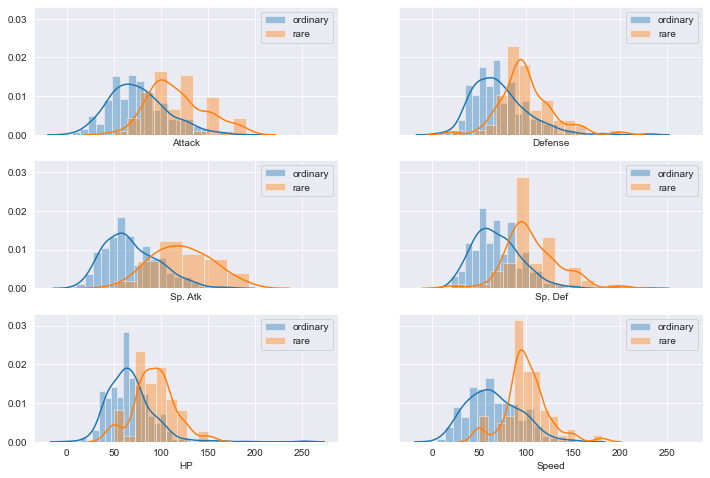

In [48]:
# I'll create two dataframes: rare and ordinary with respective pokemon. Then plot distributions of their attributes

# dataframes
rare_pokemon = pokemon[pokemon["Legendary"]==True]
ord_pokemon = pokemon[pokemon["Legendary"]==False]

# plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8), sharex=True, sharey=True)
sns.distplot(ord_pokemon["Attack"], label="ordinary", ax=axes[0,0])
sns.distplot(rare_pokemon["Attack"], label="rare", ax=axes[0,0])
axes[0,0].legend(loc="upper right")
sns.distplot(ord_pokemon["Defense"], label="ordinary", ax=axes[0,1])
sns.distplot(rare_pokemon["Defense"], label="rare", ax=axes[0,1])
axes[0,1].legend(loc="upper right")
sns.distplot(ord_pokemon["Sp. Atk"], label="ordinary", ax=axes[1,0])
sns.distplot(rare_pokemon["Sp. Atk"], label="rare", ax=axes[1,0])
axes[1,0].legend(loc="upper right")
sns.distplot(ord_pokemon["Sp. Def"], label="ordinary", ax=axes[1,1])
sns.distplot(rare_pokemon["Sp. Def"], label="rare", ax=axes[1,1])
axes[1,1].legend(loc="upper right")
sns.distplot(ord_pokemon["HP"], label="ordinary", ax=axes[2,0])
sns.distplot(rare_pokemon["HP"], label="rare", ax=axes[2,0])
axes[2,0].legend(loc="upper right")
sns.distplot(ord_pokemon["Speed"], label="ordinary", ax=axes[2,1])
sns.distplot(rare_pokemon["Speed"], label="rare", ax=axes[2,1])
axes[2,1].legend(loc="upper right");

### Well, yes. In general, rare pokemon are stronger than usual ones!

### Now, I have to list 10 pokemon with most wins. I want to value sort through "Winner" column in combats dataset and get those 10 pokemon ids, then list the names of pokemons according to their ids from "pid" column in pokemon dataset.

In [49]:
# 10 pokemon ids with most wins
most_wins = combats["Winner"].value_counts()[:10]

print(f"10 pokemons with most wins:")
print(" ")
for pid,value in zip(list(most_wins.index),list(most_wins.values)):
    print(f"{pokemon[pokemon['pid']==pid]['Name'].values[0]} with {value} wins")

10 pokemons with most wins:
 
Mewtwo with 152 wins
Aerodactyl with 136 wins
Infernape with 136 wins
Jirachi with 134 wins
Deoxys Speed Forme with 133 wins
Slaking with 133 wins
Murkrow with 130 wins
Mega Absol with 130 wins
Mega Houndoom with 128 wins
Mega Aerodactyl with 127 wins


### Mewtwo pokemon has 152 wins! Let's check him out.

In [50]:
pokemon[pokemon["Name"]=="Mewtwo"]

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense ratio,Sp.Atk/Sp.Def ratio
162,163,Mewtwo,Psychic,0,106,110,90,154,90,130,True,1.222222,1.711111


### Well, he looks like the one to be winning many combats: all physical attributes are above the average, durable and fast, well balanced in his attack and defense. Rare pokemon!

### Now, Professor Oak suspects that Pokémon in the grass class have a stronger regular attack than those in the rock class. Check if he is right and convince him of your conclusion with statistical arguments. Note: If there are Pokémon that are in both classes, discard them.

### First, find pokemon belonging to both classes (if there are any). Then, create to dataframes of only grass and only rock classes (as one of the classes) and get rid of those belonging to both. Third, check their stats: attributes distribution, number and percentage of wins.

In [51]:
# pokemon belonging to both classes
grass_rock_class = pokemon[((pokemon["Class 1"]=="Grass")&(pokemon["Class 2"]=="Rock"))|
                           ((pokemon["Class 1"]=="Rock")&(pokemon["Class 2"]=="Grass"))]
grass_rock_class

,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense ratio,Sp.Atk/Sp.Def ratio
377,378,Lileep,Rock,Grass,66,41,77,61,87,23,False,0.532468,0.701149
378,379,Cradily,Rock,Grass,86,81,97,81,107,43,False,0.835052,0.757009


In [52]:
# pokemon in grass class excluding those two belonging to both classes
grass_class = pokemon[(pokemon["Class 1"]=="Grass")|(pokemon["Class 2"]=="Grass")]
grass_class.drop([377,378], axis=0, inplace=True)

# pokemon in rock class excluding those two belonging to both classes
rock_class = pokemon[(pokemon["Class 1"]=="Rock")|(pokemon["Class 2"]=="Rock")]
rock_class.drop([377,378], axis=0, inplace=True)

In [53]:
print(f"There are {len(grass_class)} pokemon in grass class and {len(rock_class)} in rock class")

There are 93 pokemon in grass class and 56 in rock class


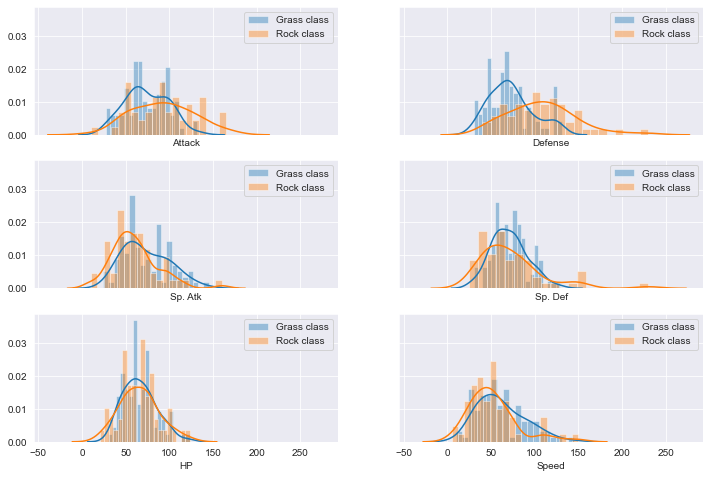

In [56]:
# plotting attributes distribution
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8), sharex=True, sharey=True)
sns.distplot(grass_class["Attack"], bins=20, ax=axes[0,0], label="Grass class")
sns.distplot(rock_class["Attack"], bins=20, ax=axes[0,0], label="Rock class")
axes[0,0].legend(loc="upper right")
sns.distplot(grass_class["Defense"], bins=20, ax=axes[0,1], label="Grass class")
sns.distplot(rock_class["Defense"], bins=20, ax=axes[0,1], label="Rock class")
axes[0,1].legend(loc="upper right")
sns.distplot(grass_class["Sp. Atk"], bins=20, ax=axes[1,0], label="Grass class")
sns.distplot(rock_class["Sp. Atk"], bins=20, ax=axes[1,0], label="Rock class")
axes[1,0].legend(loc="upper right")
sns.distplot(grass_class["Sp. Def"], bins=20, ax=axes[1,1], label="Grass class")
sns.distplot(rock_class["Sp. Def"], bins=20, ax=axes[1,1], label="Rock class")
axes[1,1].legend(loc="upper right")
sns.distplot(grass_class["HP"], bins=20, ax=axes[2,0], label="Grass class")
sns.distplot(rock_class["HP"], bins=20, ax=axes[2,0], label="Rock class")
axes[2,0].legend(loc="upper right")
sns.distplot(grass_class["Speed"], bins=20, ax=axes[2,1], label="Grass class")
sns.distplot(rock_class["Speed"], bins=20, ax=axes[2,1], label="Rock class")
axes[2,1].legend(loc="upper right");

In [59]:
print(f"Avg attack in grass class is {round(grass_class['Attack'].mean(),2)} and {round(rock_class['Attack'].mean(),2)} in rock class")
print(f"Avg defense in grass class is {round(grass_class['Defense'].mean(),2)} and {round(rock_class['Defense'].mean(),2)} in rock class")
print(f"Avg sp. attack in grass class is {round(grass_class['Sp. Atk'].mean(),2)} and {round(rock_class['Sp. Atk'].mean(),2)} in rock class")
print(f"Avg sp. defense in grass class is {round(grass_class['Sp. Def'].mean(),2)} and {round(rock_class['Sp. Def'].mean(),2)} in rock class")
print(f"Avg hp in grass class is {round(grass_class['HP'].mean(),2)} and {round(rock_class['HP'].mean(),2)} in rock class")
print(f"Avg speed in grass class is {round(grass_class['Speed'].mean(),2)} and {round(rock_class['Speed'].mean(),2)} in rock class")

Avg attack in grass class is 73.73 and 91.79 in rock class
Avg defense in grass class is 72.96 and 107.8 in rock class
Avg sp. attack in grass class is 72.98 and 60.02 in rock class
Avg sp. defense in grass class is 70.96 and 72.98 in rock class
Avg hp in grass class is 65.84 and 65.66 in rock class
Avg speed in grass class is 61.31 and 51.75 in rock class


### Regular attack in rock class appears to be better than in grass class. It's more widely distributed and there are some pokemon in rock class with pretty high attack points. Plus, general attack in average is higher in rock than in grass class.

## All right, now it's time to create a model that will be predictiong combats outcomes. 
### I want to use tree based models: Decision tree classifier, Random forest classifier and XGBoost classifier. But I want to do some feature engineering first. Here is a plan:
### - Create new dataframes. Blue corner - pokemon ids from "First_pokemon" column in combats dataframe and red corner - pokemon from "Second_pokemon" column in combats dataset.
### - Join them and do some features engineering. 
### - Split to train and validation.
### - Train models with 10-split cross validation.
### - Evaluate the models using roc_auc_score as metric and pick the best one.

In [102]:
# blue corner dataframe
blue_corner = pd.merge(combats["First_pokemon"], pokemon, left_on="First_pokemon", right_on="pid", how="left")
blue_corner.rename(columns={"First_pokemon":"blue_corner"}, inplace=True)
blue_corner.drop("pid", axis=1, inplace=True)


# red corner dataframe
red_corner = pd.merge(combats["Second_pokemon"], pokemon, left_on="Second_pokemon", right_on="pid", how="left")
red_corner.rename(columns={"Second_pokemon":"red_corner"}, inplace=True)
red_corner.drop("pid", axis=1, inplace=True)

In [103]:
blue_corner.head()

,blue_corner,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense ratio,Sp.Atk/Sp.Def ratio
0,266,Larvitar,Rock,Ground,50,64,50,45,50,41,False,1.280000,0.900000
1,702,Virizion,Grass,Fighting,91,90,72,90,129,108,True,1.250000,0.697674
2,191,Togetic,Fairy,Flying,55,40,85,80,105,40,False,0.470588,0.761905
3,237,Slugma,Fire,0,40,40,40,70,40,20,False,1.000000,1.750000
4,151,Omastar,Rock,Water,70,60,125,115,70,55,False,0.480000,1.642857


In [104]:
red_corner.head()

,red_corner,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense ratio,Sp.Atk/Sp.Def ratio
0,298,Nuzleaf,Grass,Dark,70,70,40,60,40,60,False,1.750000,1.500000
1,701,Terrakion,Rock,Fighting,91,129,90,72,90,108,True,1.433333,0.800000
2,668,Beheeyem,Psychic,0,75,75,75,125,95,40,False,1.000000,1.315789
3,683,Druddigon,Dragon,0,77,120,90,60,90,48,False,1.333333,0.666667
4,231,Shuckle,Bug,Rock,20,10,230,10,230,5,False,0.043478,0.043478


### In order to make it easier for our model to train, I want to create a class column that will contain both classes pokemon belong to if there are or just one.

In [105]:
classes = []
for i in range(len(blue_corner)):
    if blue_corner["Class 2"][i]==0:
        classes.append(blue_corner["Class 1"][i].lower())
    else:
        classes.append(blue_corner["Class 1"][i].lower()+ "-"+blue_corner["Class 2"][i].lower())

In [106]:
blue_corner["Class"] = classes

In [107]:
# no need in Name, Class 1 and Class 2 columns anymore
blue_corner.drop(["Name","Class 1","Class 2"], axis=1, inplace=True)

In [108]:
blue_corner.head()

,blue_corner,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense ratio,Sp.Atk/Sp.Def ratio,Class
0,266,50,64,50,45,50,41,False,1.280000,0.900000,rock-ground
1,702,91,90,72,90,129,108,True,1.250000,0.697674,grass-fighting
2,191,55,40,85,80,105,40,False,0.470588,0.761905,fairy-flying
3,237,40,40,40,70,40,20,False,1.000000,1.750000,fire
4,151,70,60,125,115,70,55,False,0.480000,1.642857,rock-water


In [109]:
# same for the red corner
classes = []
for i in range(len(red_corner)):
    if red_corner["Class 2"][i]==0:
        classes.append(red_corner["Class 1"][i].lower())
    else:
        classes.append(red_corner["Class 1"][i].lower()+ "-"+red_corner["Class 2"][i].lower())

# new Class column
red_corner["Class"] = classes   

# no need in Name, Class 1 and Class 2 columns anymore
red_corner.drop(["Name","Class 1","Class 2"], axis=1, inplace=True)

# see what we've got
red_corner.head()

,red_corner,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Attack/Defense ratio,Sp.Atk/Sp.Def ratio,Class
0,298,70,70,40,60,40,60,False,1.750000,1.500000,grass-dark
1,701,91,129,90,72,90,108,True,1.433333,0.800000,rock-fighting
2,668,75,75,75,125,95,40,False,1.000000,1.315789,psychic
3,683,77,120,90,60,90,48,False,1.333333,0.666667,dragon
4,231,20,10,230,10,230,5,False,0.043478,0.043478,bug-rock


### Join dataframes into fight_stats

In [110]:
# join them
fight_stats = blue_corner.join(red_corner, lsuffix="_blue", rsuffix="_red")
fight_stats.head()

,blue_corner,HP_blue,Attack_blue,Defense_blue,Sp. Atk_blue,Sp. Def_blue,Speed_blue,Legendary_blue,Attack/Defense ratio_blue,Sp.Atk/Sp.Def ratio_blue,...,HP_red,Attack_red,Defense_red,Sp. Atk_red,Sp. Def_red,Speed_red,Legendary_red,Attack/Defense ratio_red,Sp.Atk/Sp.Def ratio_red,Class_red
0,266,50,64,50,45,50,41,False,1.280000,0.900000,...,70,70,40,60,40,60,False,1.750000,1.500000,grass-dark
1,702,91,90,72,90,129,108,True,1.250000,0.697674,...,91,129,90,72,90,108,True,1.433333,0.800000,rock-fighting
2,191,55,40,85,80,105,40,False,0.470588,0.761905,...,75,75,75,125,95,40,False,1.000000,1.315789,psychic
3,237,40,40,40,70,40,20,False,1.000000,1.750000,...,77,120,90,60,90,48,False,1.333333,0.666667,dragon
4,151,70,60,125,115,70,55,False,0.480000,1.642857,...,20,10,230,10,230,5,False,0.043478,0.043478,bug-rock


### Now creating new columns with pokemons' attributes differences.

In [111]:
# new columns
fight_stats["HP_dif"] = fight_stats["HP_blue"] - fight_stats["HP_red"]
fight_stats["Attack_dif"] = fight_stats["Attack_blue"] - fight_stats["Attack_red"]
fight_stats["Defense_dif"] = fight_stats["Defense_blue"] - fight_stats["Defense_red"]
fight_stats["Sp. Atk dif"] = fight_stats["Sp. Atk_blue"] - fight_stats["Sp. Atk_red"]
fight_stats["Sp. Def dif"] = fight_stats["Sp. Def_blue"] - fight_stats["Sp. Def_red"]
fight_stats["Speed_dif"] = fight_stats["Speed_blue"] - fight_stats["Speed_red"]

### And a target column.

In [112]:
# since i have blue corner first, if blue corner wins - put 1, if red wins - 0
# i'll call the column "blue_won"
fight_stats["blue_won"] = [1 if fight_stats["blue_corner"][i]==combats["Winner"][i] else 0 for i in range(len(combats))]

In [113]:
# see what we have
fight_stats.head()

,blue_corner,HP_blue,Attack_blue,Defense_blue,Sp. Atk_blue,Sp. Def_blue,Speed_blue,Legendary_blue,Attack/Defense ratio_blue,Sp.Atk/Sp.Def ratio_blue,...,Attack/Defense ratio_red,Sp.Atk/Sp.Def ratio_red,Class_red,HP_dif,Attack_dif,Defense_dif,Sp. Atk dif,Sp. Def dif,Speed_dif,blue_won
0,266,50,64,50,45,50,41,False,1.280000,0.900000,...,1.750000,1.500000,grass-dark,-20,-6,10,-15,10,-19,0
1,702,91,90,72,90,129,108,True,1.250000,0.697674,...,1.433333,0.800000,rock-fighting,0,-39,-18,18,39,0,0
2,191,55,40,85,80,105,40,False,0.470588,0.761905,...,1.000000,1.315789,psychic,-20,-35,10,-45,10,0,0
3,237,40,40,40,70,40,20,False,1.000000,1.750000,...,1.333333,0.666667,dragon,-37,-80,-50,10,-50,-28,0
4,151,70,60,125,115,70,55,False,0.480000,1.642857,...,0.043478,0.043478,bug-rock,50,50,-105,105,-160,50,1


In [114]:
fight_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   blue_corner                50000 non-null  int64  
 1   HP_blue                    50000 non-null  int64  
 2   Attack_blue                50000 non-null  int64  
 3   Defense_blue               50000 non-null  int64  
 4   Sp. Atk_blue               50000 non-null  int64  
 5   Sp. Def_blue               50000 non-null  int64  
 6   Speed_blue                 50000 non-null  int64  
 7   Legendary_blue             50000 non-null  bool   
 8   Attack/Defense ratio_blue  50000 non-null  float64
 9   Sp.Atk/Sp.Def ratio_blue   50000 non-null  float64
 10  Class_blue                 50000 non-null  object 
 11  red_corner                 50000 non-null  int64  
 12  HP_red                     50000 non-null  int64  
 13  Attack_red                 50000 non-null  int

### Now, I need numeric columns for normilizing, categorical for label encoding.

In [115]:
# numeric columns to normilize
numeric = fight_stats.select_dtypes(exclude=["object","bool"]).columns.to_list()

In [116]:
# remove id columns
numeric.remove("blue_corner")
numeric.remove("red_corner")
# remove target column
numeric.remove("blue_won")

In [117]:
# categorical columns to label encode
categorical = fight_stats.select_dtypes(include=["object","bool"]).columns.to_list()

In [118]:
# scaling 
fight_stats[numeric] = StandardScaler().fit_transform(fight_stats[numeric])

In [119]:
# and encoding
for col in categorical:
    fight_stats[col] = LabelEncoder().fit_transform(fight_stats[col])

In [120]:
fight_stats.head()

,blue_corner,HP_blue,Attack_blue,Defense_blue,Sp. Atk_blue,Sp. Def_blue,Speed_blue,Legendary_blue,Attack/Defense ratio_blue,Sp.Atk/Sp.Def ratio_blue,...,Attack/Defense ratio_red,Sp.Atk/Sp.Def ratio_red,Class_red,HP_dif,Attack_dif,Defense_dif,Sp. Atk dif,Sp. Def dif,Speed_dif,blue_won
0,266,-0.754321,-0.462551,-0.766510,-0.851845,-0.790834,-0.929200,0,0.207004,-0.331522,...,1.081698,0.881886,67,-0.561445,-0.131851,0.221371,-0.329777,0.252015,-0.458032,0
1,702,0.867711,0.332786,-0.071078,0.522399,2.039072,1.358426,1,0.153991,-0.725597,...,0.500829,-0.536230,122,0.000928,-0.846791,-0.404726,0.384791,0.987164,0.001567,0
2,191,-0.556512,-1.196708,0.339860,0.217011,1.179354,-0.963344,0,-1.223326,-0.600494,...,-0.294044,0.508698,109,-0.561445,-0.760132,0.221371,-0.979384,0.252015,0.001567,0
3,237,-1.149938,-1.196708,-1.082615,-0.088376,-1.149050,-1.646217,0,-0.287790,1.324047,...,0.317397,-0.806347,21,-1.039462,-1.735050,-1.120266,0.211562,-1.268984,-0.675737,0
4,151,0.036914,-0.584910,1.604282,1.285868,-0.074402,-0.451189,0,-1.206695,1.115362,...,-2.048612,-2.068852,9,1.406862,1.081381,-2.350100,2.268651,-4.057481,1.211039,1


### Now, I want to shuffle up the data for good measure and split to train and test. Before that, I don't think I need columns with pokemon ids anymore, so I'll drop them and split to X - features columns and y - target column.

In [121]:
# shuffle
fight_stats = shuffle(fight_stats)

# features and target
X = fight_stats.drop(["blue_corner","red_corner","blue_won"], axis=1)
y = fight_stats["blue_won"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model training!

In [124]:
%%time 
# time it to see how long it takes
# shuffled 10-split for cross validation
shuffle_split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# models to train
d_tree = DecisionTreeClassifier()
rfc = RandomForestClassifier()
xgb = XGBClassifier()
models = {"Decision tree":d_tree,"Random forest":rfc,"XGBoost":xgb}

# training
for label,model in models.items():
    score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=shuffle_split, scoring="roc_auc").mean()
    print(f"{label}'s avg ROC_AUC_SCORE is {score}")

Decision tree's avg ROC_AUC_SCORE is 0.9260542495252541
Random forest's avg ROC_AUC_SCORE is 0.9849867979869517
XGBoost's avg ROC_AUC_SCORE is 0.9904788166132905
Wall time: 2min 40s


### Both Random forest and XGBoost performed really well. I'd like to test them both and see which one is faster (spoiler alert! XGBoost). 
##### I was actually very surprised by results and checked if there was data leakage somewhere but I couldn't find it. If I did a mistake or did it completely wrong, please, let me know.

In [136]:
%%time
# random forest
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_proba = rfc.predict_proba(X_test)[:,1]

Wall time: 14.7 s


In [137]:
# score
roc_auc_score(y_test,rfc_proba)

0.985926633997903

In [138]:
%%time
# xgboost
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
xgb_proba = xgb.predict_proba(X_test)[:,1]

Wall time: 4.35 s


In [141]:
# score
roc_auc_score(y_test,xgb_proba)

0.9912128687450406

### So, not only XGBoost performed slightly better (about 0.5%), it's actually 3 times faster.

In [143]:
# save the best model
with open("xgboost_031220.pickle", "wb") as f:
    pickle.dump(xgb,f)

### I guess at this point a good solution for rankings could be number of wins in combats. And I've already listed 10 pokemons with most wins above. The objective now is to try to scale up in case there are 1 billion rows in the dataset instead of 50k. I'm very knew to this and didn't get a chance to work with big data yet. So, I couldn't come up with a solution to this one.

### Here is my code for the sampled datasets. I just went through "Winners" columns in combats dataset and value counted. Pokemon name then found in pokemon dataset by its pid.

In [146]:
# 10 pokemon ids with most wins
most_wins = combats["Winner"].value_counts()[:10]

print(f"10 pokemons with most wins:")
print(" ")
for pid,value in zip(list(most_wins.index),list(most_wins.values)):
    print(f"{pokemon[pokemon['pid']==pid]['Name'].values[0]} with {value} wins")

10 pokemons with most wins:
 
Mewtwo with 152 wins
Aerodactyl with 136 wins
Infernape with 136 wins
Jirachi with 134 wins
Deoxys Speed Forme with 133 wins
Slaking with 133 wins
Murkrow with 130 wins
Mega Absol with 130 wins
Mega Houndoom with 128 wins
Mega Aerodactyl with 127 wins
